##Importing the necessary libraries##

In [196]:
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from google.colab import drive
drive.mount('/content/gdrive')
import random
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import numpy as np
import random

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [233]:
class Rectangle:
    def __init__(self, x=0, y=0, width=0, height=0):
        self.x = x
        self.y = y
        self.width = width
        self.height = height

class Node:
    def __init__(self, value, width=None, height=None):
        self.value = value
        self.width = width
        self.height = height
        self.left = None
        self.right = None

class FloorplanDetails:
    def __init__(self):
        self.max_x = 0
        self.max_y = 0
        self.enclosed_area = 0
        self.wiring = 0

In [234]:
def take_input(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        num_blocks = int(lines[0].split('=')[1])

        # Reading adjacency matrix
        adj= np.zeros((num_blocks, num_blocks), dtype=int)
        for i, line in enumerate(lines[2:num_blocks+2]):  # Fix the index here
            if line.strip():  # Check if line is not empty
                adj[i] = list(map(int, line.strip('{}\n').split()))

        # Reading blocks data
        blocks = []
        for line in lines[num_blocks+1:num_blocks*2+3]:  # Fix the index here
            block_info = line.strip('{}\n').split()
            if len(block_info) == 3:
                blocks.append((block_info[0], float(block_info[1]), float(block_info[2]),float(block_info[2])*float(block_info[1])))
                #passing area of the block as well to avoid recalculation.

        # Reading Polish expression
        polish_expression = lines[num_blocks*2+4].strip()  # Fix the index here
        return num_blocks,adj,blocks,polish_expression

In [283]:

def find_floorplan_area(pe,num_blocks,blocks):
  global area
  area=0
  #print(blocks)
  curmax=num_blocks
  stack=[]
  for c in pe:
    if c.isdigit():
      stack.append(int(c))
    elif c=='V':
      el1=stack.pop()
      el2=stack.pop()
      el1-=1
      el2-=1
      curht=max(blocks[el1][2],blocks[el2][2])
      curwid=blocks[el2][1]+blocks[el1][1]
      curmax+=1
      blocks.append((curmax, float(curwid), float(curht), float(curwid) * float(curht)))

      stack.append(curmax)
    elif c=='H':
      el1=stack.pop()
      el2=stack.pop()
      el1-=1
      el2-=1
      curwd=max(blocks[el1][1],blocks[el2][1])
      curht=blocks[el2][2]+blocks[el1][2]
      curmax+=1
      blocks.append((curmax, float(curwid), float(curht), float(curwid) * float(curht)))
      stack.append(curmax)
  area=blocks[-1][3]

In [284]:

def find_plot_limits(blocks):
  global xmax, ymax
  xmax=-1
  ymax=-1
  for row in blocks:
    #print(row[1],":",row[0])
    xmax=max(xmax,row[1])#max width
    ymax=max(ymax,row[2])#max height

In [285]:
def make_binary_tree(polish_expression, blocks):
    stack = []
    for token in polish_expression:
        if token.isnumeric():
            # If the token is a number, create a leaf node with block dimensions and push onto the stack
            block_id = token
            block_data = next(data for data in blocks if data[0] == block_id)
            node = Node(value=int(block_id), width=block_data[1], height=block_data[2])  # Corrected assignment
            stack.append(node)
        elif token == 'H' or token == 'V':
            # If the token is an operator, pop the top two nodes and create a new internal node
            operand2 = stack.pop()
            operand1 = stack.pop()
            new_node = Node(value=token)
            new_node.left = operand1
            new_node.right = operand2
            # Update the breadth and height of the new internal node based on the operation
            if token == 'H':
                new_node.width = max(operand1.width, operand2.width)
                new_node.height = operand1.height + operand2.height
            elif token == 'V':
                new_node.width = operand1.width + operand2.width
                new_node.height = max(operand1.height, operand2.height)
            stack.append(new_node)

    # The top of the stack now contains the root of the tree
    return stack[0]

In [286]:
def print_binary_tree(node, level=1):
    if node is not None:
        print("  " * level + f"{node.value} ({node.width}, {node.height})")
        print_binary_tree(node.left, level + 1)
        print_binary_tree(node.right, level + 1)

In [287]:
def plot_binary_tree(ax, node, x, y, scale):
  details = FloorplanDetails()  # To store floorplan details

  if node is not None:
    if isinstance(node.value, int):
            # If it's a leaf node (rectangle), plot the rectangle
      rectangle_id = node.value
      plot_current_rectangle(ax, x, y, node.width * scale, node.height * scale, rectangle_id, details)
    else:
            # If it's an internal node (operator), recursively plot its children
      left_details = plot_binary_tree(ax, node.left, x, y, scale)
      if node.value == 'H':
        right_details = plot_binary_tree(ax, node.right, x, y + node.left.height * scale, scale)
      elif node.value == 'V':
        right_details = plot_binary_tree(ax, node.right, x + node.left.width * scale, y, scale)

            # Update floorplan details
      details.floorplan = [Rectangle(x, y, node.left.width * scale, node.left.height * scale),
                                 Rectangle(x, y, node.right.width * scale, node.right.height * scale)]
      details.max_x = max(left_details.max_x, right_details.max_x)
      details.max_y = max(left_details.max_y, right_details.max_y)
  return details

In [288]:
rectangle_centers=[]
def plot_current_rectangle(ax, x, y, width, height, rectangle_id, details):
    # Generate a random color for the border
    border_color = np.random.rand(4,)
    curcentre_x=x+(width)/2
    curcentre_y=y+(height)/2
    rectangle_centers.append((rectangle_id,curcentre_x,curcentre_y))

    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor=border_color, facecolor='none')
    ax.add_patch(rect)

    # Display rectangle ID in the center
    ax.text(x + width / 2, y + height / 2, str(rectangle_id),
            ha='center', va='center', fontsize=8, color='black')

    # Update floorplan details
    details.max_x = max(details.max_x, x + width)
    details.max_y = max(details.max_y, y + height)

def plot_rectangle_centers(ax, centers):
    ids, xs, ys = zip(*centers)
    ax.scatter(xs, ys, c='red', marker='o', label='Center Points')

In [326]:
def wirelength_estimation(rectangle_centers_one,adj):
  global wirelength_total
  wirelength_total=0
  n=len(adj)
  st = set()
  for i in range(1, n):
    curwirelen = 0
    for j in range(1, n):
      if (i, j) not in st and i!=j:
        curx1 = rectangle_centers_one[i][1]
        curx2 = rectangle_centers_one[j][1]
        cury1=rectangle_centers_one[i][2]
        cury2=rectangle_centers_one[j][2]
        manhattan_dist = abs(curx1 - curx2) + abs(cury1 - cury2)
        curwirelen += manhattan_dist * adj[i-1][j-1] #as adj is 0 indexed.
        st.add((i, j))
    wirelength_total += curwirelen

In [331]:
def total_cost(wirelength,area):
  global cost
  cost=0
  cost=0.75*wirelength+0.25*area

In [336]:
def main():
  file_path="/content/gdrive/MyDrive/test_data.txt"
  num_blocks, adj, blocks, polish_expression =take_input(file_path)
  #finding xmax and ymax.
  find_floorplan_area(polish_expression,num_blocks,blocks)
  find_plot_limits(blocks)

  print("Polish Expression:", polish_expression)

  print("Size of the minimum enclosing rectangle:" ,area)
  root_node = make_binary_tree(polish_expression,blocks)

  fig, ax = plt.subplots()
  details = plot_binary_tree(ax, root_node, 0, 0, 1)
  plot_rectangle_centers(ax,rectangle_centers)
  rectangle_centers_one = [()] + rectangle_centers
  wirelength_estimation(rectangle_centers_one,adj)
  ax.set_xlim(0, xmax+10)  # Adjust x-axis limits
  ax.set_ylim(0,ymax+10)  # Adjust y-axis limits
  ax.set_aspect('equal', adjustable='box')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title('Floorplan')
  plt.grid(False)
  plt.show()
  print("Total Wirelength:",wirelength_total)
  total_cost(wirelength_total,area)
  print("Total Cost:",cost)
  rectangle_centers.clear()#so it doesnt keep adding blocks everytime we call function.
  #print(blocks)

Polish Expression: 1 2 V 3 H 4 5 6 V H 7 V H
Size of the minimum enclosing rectangle: 1000.0


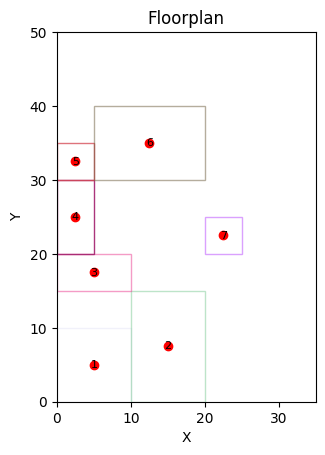

Total Wirelength: 735.0
Total Cost: 801.25


In [337]:
main()